# Отток клиентов из банка

Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59.

## Подготовка данных

In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np # импорт библиотеки numpy
from sklearn.tree import DecisionTreeClassifier # импорт из библиотеки sklearn алгоритма дерева решений
from sklearn.metrics import f1_score, roc_curve, roc_auc_score # импорт из библиотеки sklearn функции метрики качества f1, roc_curve, roc_auc
from sklearn.ensemble import RandomForestClassifier # импорт из библиотеки sklearn алгоритма случайного леса
from sklearn.linear_model import LogisticRegression # импорт из библиотеки sklearn алгоритма логистической регрессии
from sklearn.model_selection import train_test_split # импорт из библиотеки sklearn функции разделения выборок
from sklearn.preprocessing import StandardScaler # импорт из библиотеки sklearn функции StandardScaler
from sklearn.utils import shuffle # импорт из библиотеки sklearn функции shuffle
import matplotlib.pyplot as plt # импорт из библиотеки matplotlib функции построения графиков
import warnings # импорт библиотеки warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('***.csv') # прочитаем файл
df.info() # общая информация
df.head() # первые пять строк датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Описание данных**

Признаки:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
* `Exited` — факт ухода клиента

**Выводы:**

В данных есть пропуски в столбце сколько лет человек является клиентом банка. У нас порядка 10% пропусков, их можно удалить. Так как это учебный проект, мы не можем запросить недостающие данные.

Так же замечено нарушение змеиного регистра в названии столбцов. Так же есть столбцы, которые не нужны для обучения моделей, они не влияют на конечный результат, их можно удалить. Это столбцы с индексом строки в данных, уникальный идентификатор клиента, фамилия.

### Подготовка данных

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1) # удаление столбцов

In [4]:
# переименование столбцов
df = df.rename(columns = {'CreditScore':'credit_score',
                          'Geography':'geography',
                          'Gender':'gender',
                          'Age':'age',
                          'Tenure':'tenure',
                          'Balance':'balance',
                          'NumOfProducts':'num_of_products',
                          'HasCrCard':'has_cr_card',
                          'IsActiveMember':'is_active_member',
                          'EstimatedSalary':'estimated_salary',
                          'Exited':'exited'
                          })
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.describe() # описание датасета

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
print(df['geography'].value_counts()) # уникальные значения столбца 'geography'
df['gender'].value_counts() # уникальные значения столбца 'gender'

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64


Male      5457
Female    4543
Name: gender, dtype: int64

С данными все в порядке.

### Обработка пропусков

In [7]:
df = df.dropna().reset_index(drop=True) # удаляем строки с пропущенными значениями

### Преобразование категориальных признаков в численные

Осталось 2 столбца с категориальными признаками с типом object, преобразуем их в численные.

In [8]:
#преобразование категориальных признаков в численные
df = pd.get_dummies(df, columns=['geography','gender'], drop_first=True)

### Разделение на выборки

In [9]:
features = df.drop(['exited'], axis =1) # определяю признаки
target = df['exited'] # определяю целевой признак

In [10]:
features_train, features_test , target_train, target_test = train_test_split(
    features, target, train_size=0.6, random_state=42) # отделение 60% данных для обучающей выборки

In [11]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=42) 
# разделение оставшихся данных на тестовую и валидационную выборки

Проверим разделение выборок:

In [12]:
print('Обучающая выборка:',round(features_train.shape[0]/features.shape[0]*100,1),'%')
print('Валидационная выборка:',round(features_valid.shape[0]/features.shape[0]*100,1),'%')
print('Тестовая выборка:',round(features_test.shape[0]/features.shape[0]*100,1),'%')

Обучающая выборка: 60.0 %
Валидационная выборка: 20.0 %
Тестовая выборка: 20.0 %


### Масштабирование признаков

In [13]:
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [14]:
numeric = ['credit_score','age','tenure','balance','estimated_salary']

scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Данные подготовлены для исследования и построения моделей.

## Исследование задачи

Исследуем баланс классов, обучим модель без учёта дисбаланса.

In [15]:
target.value_counts(normalize=True) # смотриим баланс классов

0    0.796062
1    0.203938
Name: exited, dtype: float64

80% отрицательного класса и 20% положительного. Наблюдается большой дисбаланс классов. Метрика Accuracy не подходит для проверки модели из-за дисбаланса классов. Воспользуемся метрикой F1.

**DecisionTreeClassifier**

Напишем функцию для подбора гиперпараметров и обучения Дерева Решений с выводом F1.

In [16]:
def tree(features_tr, target_tr, weight):
    best_model = None
    best_result = 0
    for depth in range(1,10):
        model = DecisionTreeClassifier(random_state=42, max_depth=depth, class_weight=weight)
        model.fit(features_tr, target_tr) # обучение модели
        predictions_valid = model.predict(features_valid) # применение модели на валидационной выборке
        result = f1_score(target_valid, predictions_valid) # применение модели на валидационной выборке
        if result > best_result:
            best_model = model
            best_result = result
    return best_result, best_model

In [17]:
print('F1-мера лучшей модели:', tree(features_train, target_train, None)) # применение функции на тренировочной выборке

F1-мера лучшей модели: (0.565587734241908, DecisionTreeClassifier(max_depth=8, random_state=42))


**RandomForestClassifier**

Напишем функцию для подбора гиперпараметров и обучения Случайного Леса с выводом F1.

In [18]:
def forest(features_tr, target_tr, weight):
    best_model = None
    best_result = 0
    for est in np.arange(1,52,5):
        for depth in range(1,21):
            model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth = depth, class_weight=weight)
            model.fit(features_tr, target_tr) # обучение модели
            predicted_valid = model.predict(features_valid) # предсказанные значения
            result = f1_score(target_valid, predicted_valid) # применение модели на валидационной выборке
            if result > best_result:
                best_model = model
                best_result = result
    return best_result, best_model

In [19]:
print('F1-мера лучшей модели:', forest(features_train, target_train, None)) # применение функции на тренировочной выборке

F1-мера лучшей модели: (0.5909090909090909, RandomForestClassifier(max_depth=17, n_estimators=11, random_state=42))


**LogisticRegression**

Напишем функцию для обучения Логистической Регрессии с выводом F1.

In [20]:
def logistic(features_tr, target_tr, weight):
    model_logistic = LogisticRegression(max_iter=1000, random_state=42, solver = 'liblinear', class_weight=weight)
    model_logistic.fit(features_tr, target_tr) # обучение модели
    predicted_valid = model_logistic.predict(features_valid) # предсказания
    return f1_score(target_valid, predicted_valid) # применение модели на валидационной выборке

In [21]:
print('F1-мера лучшей модели:', logistic(features_train, target_train, None)) # применение функции на тренировочной выборке

F1-мера лучшей модели: 0.27886710239651413


**Метрика AUC-ROC лучшей модели.**

Напишем функцию для построения ROC-кривой и вывода AUC-ROC лучшей модели.

In [22]:
def auc_roc(features_tr, target_tr, depth, est, weight):
    model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=42, class_weight=weight)
    model.fit(features_tr, target_tr)
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.grid()
    
    return roc_auc_score(target_valid, probabilities_one_valid)

AUC_ROC лучшей модели: 0.8248415915545831


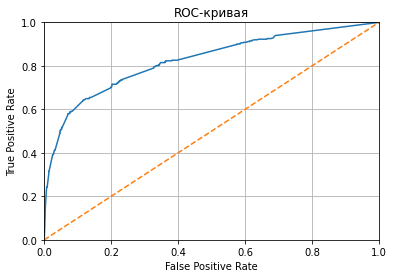

In [23]:
print('AUC_ROC лучшей модели:', auc_roc(features_train, target_train, 17, 11, None))

**Выводы:**

Результаты исследования моделей без учета дисбаланса:

    - DecisionTreeClassifier: 0.566
    - RandomForestClassifier: 0.591
    - LogisticRegression:     0.279

AUC_ROC: 0.825

На тестовой выборке качество уменьшиться еще, и мы не получим желаемый результат. Дисбаланс необходимо убирать.

Метрика AUC_ROC заметно отличается от метрики F1. Из графика видно, что модель значительно лучше случайной.

## Борьба с дисбалансом

Улучшим качество моделей, учитывая дисбаланс классов.

### Сбалансируем классы, добавив аргумент class_weight.

**DecisionTreeClassifier**

In [24]:
print('F1-мера лучшей модели:', tree(features_train, target_train, 'balanced'))

F1-мера лучшей модели: (0.59837019790454, DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=42))


**RandomForestClassifier**

In [25]:
print('F1-мера лучшей модели:', forest(features_train, target_train, 'balanced'))

F1-мера лучшей модели: (0.6208869814020028, RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=46,
                       random_state=42))


**LogisticRegression**

In [26]:
print('F1-мера лучшей модели:', logistic(features_train, target_train, 'balanced'))

F1-мера лучшей модели: 0.4765625


#### Метрика AUC-ROC наилучшей модели.

AUC_ROC лучшей модели: 0.8587823310594311


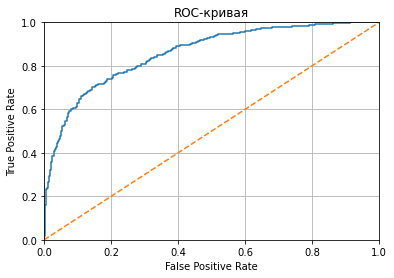

In [27]:
print('AUC_ROC лучшей модели:', auc_roc(features_train, target_train, 10, 46, 'balanced'))

Результаты исследования моделей с учетом дисбаланса с добавлением аргумента class_weight:

    - DecisionTreeClassifier: 0.598 (+0,032)
    - RandomForestClassifier: 0.621 (+0,030)
    - LogisticRegression:     0.477 (+0,198) 

AUC_ROC: 0.859 (+0.034)

### Сбалансируем классы, методом увеличения выборки. Upsampling.

In [28]:
def upsample(feature, target, repeat):
    feature_one = feature[target == 1]
    target_one = target[target == 1]
    feature_zero = feature[target == 0]
    target_zero = target[target == 0]
    
    features_upsampled = pd.concat([feature_zero] + [feature_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 42)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [29]:
# проверка
print(features_upsampled.shape)
print(target_upsampled.shape)

(8787, 11)
(8787,)


**DecisionTreeClassifier**

In [30]:
print('F1-мера лучшей модели:', tree(features_upsampled, target_upsampled, None))

F1-мера лучшей модели: (0.59837019790454, DecisionTreeClassifier(max_depth=8, random_state=42))


**RandomForestClassifier**

In [31]:
print('F1-мера лучшей модели:', forest(features_upsampled, target_upsampled, None))

F1-мера лучшей модели: (0.6227709190672155, RandomForestClassifier(max_depth=12, n_estimators=36, random_state=42))


**LogisticRegression**

In [32]:
print('F1-мера лучшей модели:', logistic(features_upsampled, target_upsampled, None))

F1-мера лучшей модели: 0.4768339768339768


#### Метрика AUC-ROC наилучшей модели.

AUC_ROC лучшей модели: 0.8514487120663439


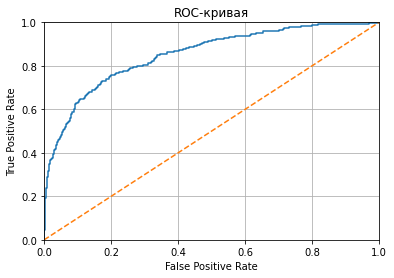

In [33]:
print('AUC_ROC лучшей модели:', auc_roc(features_upsampled, target_upsampled, 12, 36, None))

Результаты исследования моделей с учетом дисбаланса с помощью увеличения выборки.:

    - DecisionTreeClassifier: 0.598 (+0,032)
    - RandomForestClassifier: 0.623 (+0,032)
    - LogisticRegression:     0.477 (+0,198)  

AUC_ROC: 0.851 (+0.026)

### Уменьшение выборки. Downsampling.

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [35]:
# проверка
print(features_downsampled.shape)
print(target_downsampled.shape)

(2197, 11)
(2197,)


**DecisionTreeClassifier**

In [36]:
print('F1-мера лучшей модели:', tree(features_downsampled, target_downsampled, None))

F1-мера лучшей модели: (0.5751072961373391, DecisionTreeClassifier(max_depth=7, random_state=42))


**RandomForestClassifier**

In [37]:
print('F1-мера лучшей модели:', forest(features_downsampled, target_downsampled, None))

F1-мера лучшей модели: (0.5911664779161948, RandomForestClassifier(max_depth=9, n_estimators=16, random_state=42))


**LogisticRegression**

In [38]:
print('F1-мера лучшей модели:', logistic(features_downsampled, target_downsampled, None))

F1-мера лучшей модели: 0.4700285442435775


#### Метрика AUC-ROC наилучшей модели.

AUC_ROC лучшей модели: 0.8422712604799842


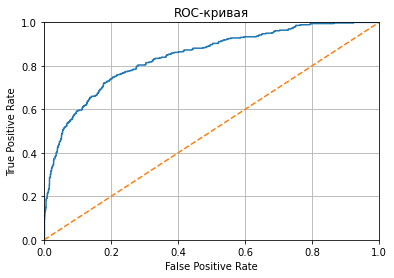

In [39]:
print('AUC_ROC лучшей модели:', auc_roc(features_downsampled, target_downsampled, 9, 16, None))

Результаты исследования моделей с учетом дисбаланса с помощью уменьшения выборки.:

    - DecisionTreeClassifier: 0.575 (+0,009)
    - RandomForestClassifier: 0.591 (без изменений)
    - LogisticRegression:     0.47 (+0,191)  

AUC_ROC: 0.842 (+0.017)

**Выводы:**

   - Лучшая модель RandomForestClassifier с учетом дисбаланса методом увеличения выборки:
   - F1-мера наилучшей модели на валидационной выборке: 0.6227709190672155
   - Лучшие гиперпараметры модели: (max_depth=12, n_estimators=36, random_state=42)
   - AUC_ROC наилучшей модели на валидационной выборке с аргументом class_weight: 0.859
   - Лучшие модели получились с методом увеличения выборки и применения аргумента class_weight.
   - Наибольшие значения AUC-ROC получаются с моделями случайного леса, так же как и значения метрики F1.
   - Метод уменьшения выборки хорош только для Линейной Регрессии, на остальные модели почти не влияет.

## Тестирование моделей

Проведем финальное тестирование лучших моделей с учетом дисбаланса тремя способами.

Напишем функцию подсчета F1 меры и auc-roc для тестовой выборки

In [40]:
def forest_test(features_tr, target_tr, weight, depth, est):
    model = RandomForestClassifier(class_weight=weight, max_depth=depth, n_estimators=est, random_state=42)
    model.fit(features_tr, target_tr)
    predicted_test = model.predict(features_test)
    score = f1_score(target_test, predicted_test)
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    return score, auc_roc

**Аргумент class_weight**

In [41]:
print('F1-мера на тестовой выборке: ', forest_test(features_train, target_train, 'balanced', 10, 46)[0])
print( 'AUC_ROC на тестовой выборке: ', forest_test(features_train, target_train, 'balanced', 10, 46)[1])

F1-мера на тестовой выборке:  0.5830985915492958
AUC_ROC на тестовой выборке:  0.8454895643263799


**Увеличение выборки**

In [42]:
print('F1-мера на тестовой выборке: ', forest_test(features_upsampled, target_upsampled, None, 12, 36)[0])
print( 'AUC_ROC на тестовой выборке: ', forest_test(features_upsampled, target_upsampled, None, 12, 36)[1])

F1-мера на тестовой выборке:  0.5945205479452054
AUC_ROC на тестовой выборке:  0.8428201433067212


**Уменьшение выборки**

In [43]:
print('F1-мера на тестовой выборке: ', forest_test(features_downsampled, target_downsampled, None, 9, 16)[0])
print( 'AUC_ROC на тестовой выборке: ', forest_test(features_downsampled, target_downsampled, None, 9, 16)[1])

F1-мера на тестовой выборке:  0.5751920965971459
AUC_ROC на тестовой выборке:  0.8409151100371327


**Влияние признаков на результат**

In [44]:
model = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=46, random_state=42)
model.fit(features_train, target_train)
pd.Series(model.feature_importances_)

0     0.086457
1     0.302842
2     0.054386
3     0.124595
4     0.183044
5     0.013512
6     0.057710
7     0.096797
8     0.046045
9     0.010558
10    0.024054
dtype: float64

Самые значимые признаки, влияющие на отток клиентов из банка по убывающей: возраст, количество продуктов банка, используемых клиентом, баланс на счёте.

**Выводы**

 - Лучшей моделью оказался случайный лес с учетом дисбаланса увеличения выборки.
 - Метод с аргументом class_weight на втором месте по точности и на третьем уменьшение выборки.
 - Наибольшее значение AUC-ROC на тестовой выборке показала модель случайного леса с аргументом class_weight!

## Общий вывод

Я исследовал и сравнил качество разных моделей с учетом дисбаланса разными методами. Аргумент class_weight, увеличение выборки, уменьшение выборки.

    - Лучшей моделью во всех трех методах оказалась RandomForestClassifier
    - Лучший результат на тестовой выборке показал метод Upsampling. F1-мера = 0.59.
    - Лучший показатель ROC-AUC на тестовой выборке достигнут с аргументом class_weight : 0.85.
    - Самые значимые признаки, влияющие на отток клиентов из банка по убывающей: возраст, количество продуктов банка, используемых клиентом, баланс на счёте.